# 3_Model_analysis
load in pickle model and run some tests best_class_tech_sc
and load in the data -mailout_train_clean

In [80]:
import pickle
import pandas as pd
import numpy as np
import PCA_functions
import Cleaning_functions
import Modeling_functions
import matplotlib.pyplot as plt

In [2]:
best_class_tech_sc = pickle.load(open('Results/XGBoost_test_1.pkl', 'rb'))

In [5]:
mailout_train_clean = PCA_functions.load_clean('mailout_train_clean')

In [8]:
def sum_diff(df, col):
    df_sum = pd.DataFrame(columns = [col + '_count', '%'])
    df_sum[col + '_count'] = df.groupby([col]).size()
    df_sum['%'] = df.groupby([col]).size()/len(df)*100
    return df_sum

In [9]:
sum_diff(mailout_train_clean, 'RESPONSE')

,RESPONSE_count,%
RESPONSE,,
0.0,33888,98.758524
1.0,426,1.241476


In [10]:
sum_diff(mailout_train_clean, 'D19_SOZIALES')

,D19_SOZIALES_count,%
D19_SOZIALES,,
0.0,9056,26.391560
1.0,11178,32.575625
2.0,1430,4.167395
3.0,8199,23.894037
4.0,3059,8.914729
5.0,1392,4.056653


In [11]:
accepts = mailout_train_clean.loc[mailout_train_clean['RESPONSE'] == 1.0]

In [12]:
accepts.shape

(426, 398)

In [14]:
sum_diff(accepts, 'D19_SOZIALES')

,D19_SOZIALES_count,%
D19_SOZIALES,,
0.0,24,5.633803
1.0,359,84.272300
2.0,8,1.877934
3.0,21,4.929577
4.0,12,2.816901
5.0,2,0.469484


That is a heavy bias in acceptance rate by D19_SOZIALES == 1.0

Witout knowing what this factor is, it's abviously some kind of social grouping. It could be a delicate one to use depending on how it's created and how it describes affluence or potentially economically vunarble social groups. This also need to be considered on what type of mailout campaign it is - if it's just advertisement and doesn't impact product price then it's safe to use

lets clean up the geniune Test data and run predictions

In [19]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

C:\Users\Hannah\AppData\Local\Temp\ipykernel_14992\4118961090.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')


In [21]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [22]:
mailout_test = Cleaning_functions.collate_unknown(mailout_test)
NaN_sum = Cleaning_functions.display_NaN(mailout_test)

In [24]:
NaN_sum.head(10)

,NaN sum,NaN %
ALTER_KIND4,42794,99.908949
ALTER_KIND3,42632,99.530736
ALTER_KIND2,42071,98.220998
ALTER_KIND1,40820,95.300353
KK_KUNDENTYP,25035,58.447926
EXTSEL992,15809,36.908458
HH_DELTA_FLAG,9619,22.456984
W_KEIT_KIND_HH,9619,22.456984
KBA05_HERST4,8537,19.930894
KBA05_FRAU,8537,19.930894


In [29]:
cols_to_drop = ['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ', 'ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1', 'EXTSEL992', 'KK_KUNDENTYP', 'HH_DELTA_FLAG', 'W_KEIT_KIND_HH']
mailout_test = Cleaning_functions.column_dropper(mailout_test, cols_to_drop)

In [30]:
NaN_sum = Cleaning_functions.display_NaN(mailout_test)
NaN_sum

,NaN sum,NaN %
KBA05_KRSVAN,8537,19.930894
KBA05_KRSHERST1,8537,19.930894
KBA05_GBZ,8537,19.930894
KBA05_HERST1,8537,19.930894
KBA05_HERST2,8537,19.930894
...,...,...
D19_VERSAND_ANZ_24,0,0.000000
D19_VERSAND_DATUM,0,0.000000
D19_VERSAND_OFFLINE_DATUM,0,0.000000
D19_VERSAND_ONLINE_DATUM,0,0.000000


In [31]:
mailout_test_drop = Cleaning_functions.row_dropper(mailout_test, 'KBA05_KW1')

In [32]:
NaN_sum = Cleaning_functions.display_NaN(mailout_test_drop)
NaN_sum.head(10)

,NaN sum,NaN %
ALTERSKATEGORIE_FEIN,1108,3.230697
D19_VERSI_ONLINE_QUOTE_12,591,1.723233
D19_GESAMT_ONLINE_QUOTE_12,591,1.723233
D19_VERSAND_ONLINE_QUOTE_12,591,1.723233
D19_KONSUMTYP,591,1.723233
D19_TELKO_ONLINE_QUOTE_12,591,1.723233
D19_LOTTO,591,1.723233
D19_BANKEN_ONLINE_QUOTE_12,591,1.723233
D19_SOZIALES,591,1.723233
RT_UEBERGROESSE,557,1.624096


In [33]:
mailout_imputed_test = Cleaning_functions.impute_all_cols(mailout_test_drop, 'most_frequent')

In [34]:
NaN_sum = Cleaning_functions.display_NaN(mailout_imputed_test)
NaN_sum.head(10)

,NaN sum,NaN %
LNR,0,0.0
KBA13_RENAULT,0,0.0
KBA13_KRSHERST_BMW_BENZ,0,0.0
KBA13_KRSHERST_AUDI_VW,0,0.0
KBA13_KRSAQUOT,0,0.0
KBA13_KMH_251,0,0.0
KBA13_KMH_250,0,0.0
KBA13_KMH_211,0,0.0
KBA13_KMH_210,0,0.0
KBA13_KMH_180,0,0.0


In [35]:
mailout_imputed_test.shape

(34296, 355)

In [37]:
CAMEO_DEU_unique = mailout_imputed_test.CAMEO_DEU_2015.unique()
CAMEO_DEU_unique = sorted(CAMEO_DEU_unique)
CAMEO_DEU_labels = ['Work_Life_Balance', 'Wealthy_Best_Ager', 'Successful-Songwriter', 'Old_Nobility', 'City_Nobility', 'Cottage_Chic', 'Noble_Jogger', 'Established_gourmet', 'Fine_Management', 'Career_Family', 
'Powershaopping_Families', 'Rural_Neighborhood', 'Secure_Retirement', 'Family_Starter', 'Family_life', 'String_Trimmer', 'Empty_Nest', 'Golden_Ager', 'Younger_Employees', 'Suddenly_family',
'Family_First', 'Stock_Market_Junkies', 'Coffee_Rider', 'Active_Retirement', 'Jobstarter', 'Petty_Bourgeois', 'Long_Established', 'Sportgardener', 'Urban_Parents', 'Frugal_Aging', 'Journeymen',
'Mantaplatte', 'Factory_Worker', 'Rear_Window', 'Interested_Retirees', 'Multi_culteral', 'Young_Mobile', 'Prefab', 'Town_Seniours', 'First_Shared_Apartment', 'Tempory_Workers', 'Afternoon_Talk_Show',
'Mini_jobber', 'Socking_Away']

In [38]:
mailout_imputed_test.CAMEO_DEU_2015 = mailout_imputed_test.CAMEO_DEU_2015.replace(CAMEO_DEU_unique, CAMEO_DEU_labels)

In [39]:
categorical_cols = ['CAMEO_DEU_2015']
mailout_test_clean = Cleaning_functions.encode_cat(mailout_imputed_test, categorical_cols)

In [40]:
mailout_test_clean.to_csv('data/mailout_test_clean.csv')

In [41]:
LNR = mailout_test_clean['LNR']

In [42]:
LNR.shape

(34296,)

In [43]:
mailout_test_to_score = mailout_test_clean.drop('LNR', axis = 1)

In [44]:
mailout_test_to_score.shape

(34296, 397)

In [51]:
cluster_centers_df = pd.read_csv('data/cluster_centers_df.csv')

In [52]:
cols = list(cluster_centers_df.columns)
cols.remove('HH_DELTA_FLAG')
cols.remove('Unnamed: 0')

In [56]:
mailout_test_to_score = mailout_test_to_score[cols]

In [60]:
mailout_test_to_score = mailout_test_to_score.astype(dtype='float64')

In [71]:
test_predictions = best_class_tech_sc.predict_proba(mailout_test_to_score)

In [76]:
Predictions = pd.DataFrame(columns = ['LNR','RESPONSE'])
Predictions['LNR'] = LNR
Predictions['RESPONSE'] = test_predictions[:, 1] 

In [77]:
Predictions.head(10)

,LNR,RESPONSE
0,1754.0,0.075972
1,1770.0,0.036268
2,1465.0,0.001578
3,1470.0,0.004005
4,1478.0,0.004440
5,1782.0,0.001274
6,1485.0,0.003528
7,1519.0,0.033477
8,1835.0,0.022018
9,1522.0,0.003567


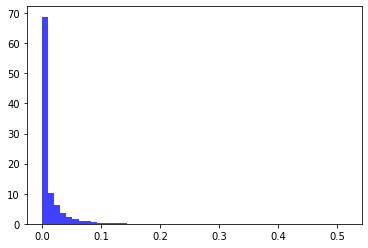

In [81]:
n, bins, patches = plt.hist(Predictions['RESPONSE'], 50, density=True, facecolor ='b', alpha=0.75)

In [82]:
Test_accepts = Predictions.loc[Predictions['RESPONSE'] >= 0.5]

In [83]:
Test_accepts.shape

(1, 2)

In [84]:
Test_accepts

,LNR,RESPONSE
33099,50447.0,0.515849


1.4% acceptance in training

This is a terrible prediction, the distribution is so skewed dispite the sample SMOTE step. I though the XGBoost and sampling would handle the class imbalance better but it's clear that the criteria for someone to have a positive RESPONSE is not being met. 

In [85]:
Test_accepts.shape[0]/Predictions.shape[0] * 100

0.0029157919290879403

It's orders of marginitude off. I'm going to apply a Logistic Regression model though the feature importance is not readily available, it has teh potential to predict with better percision over accuracy.

I split scripts here, between this and 4_Logistic_regression and bring in the results to compare here in 3_model_analysis.

In [87]:
LogModel = pickle.load(open('Results/LogModel_test.pkl', 'rb'))

In [88]:
log_test_predictions = LogModel.predict_proba(mailout_test_to_score)

In [89]:
log_Predictions = pd.DataFrame(columns = ['LNR','RESPONSE'])
log_Predictions['LNR'] = LNR
log_Predictions['RESPONSE'] = log_test_predictions[:, 1] 

In [91]:
log_Predictions.head()

,LNR,RESPONSE
0,1754.0,0.611094
1,1770.0,0.674747
2,1465.0,0.057150
3,1470.0,0.092469
4,1478.0,0.661554


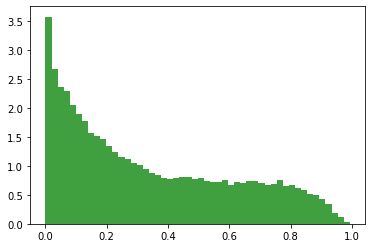

In [92]:
n, bins, patches = plt.hist(log_Predictions['RESPONSE'], 50, density=True, facecolor ='g', alpha=0.75)

In [93]:
log_test_predictions_binary = LogModel.predict(mailout_test_to_score)

In [95]:
log_Predictions_binary = pd.DataFrame(columns = ['LNR','RESPONSE'])
log_Predictions_binary['LNR'] = LNR
log_Predictions_binary['RESPONSE'] = log_test_predictions_binary

In [96]:
log_Predictions_binary.head()

,LNR,RESPONSE
0,1754.0,1
1,1770.0,1
2,1465.0,0
3,1470.0,0
4,1478.0,1


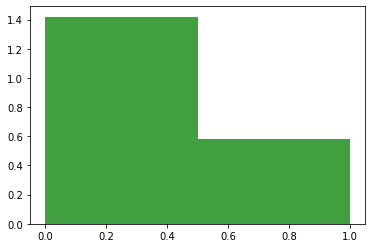

In [105]:
n, bins, patches = plt.hist(log_Predictions_binary['RESPONSE'], 2, density=True, facecolor ='g', alpha=0.75)

In [100]:
Test_accepts_log = log_Predictions_binary.loc[log_Predictions_binary['RESPONSE'] == 1]

In [101]:
Test_accepts_log.shape[0]/log_Predictions_binary.shape[0] * 100

29.041287613715884

Over predictive by a huge amount - the data was over sampled so I'm going to test some lower SMOTE values to get the VALIDATION data set balanced the ACCEPTANCE levels.

In [122]:
LogModel_2 = pickle.load(open('Results/LogModel_test_2.pkl', 'rb'))

In [104]:
log_test_predictions_2 = LogModel_2.predict_proba(mailout_test_to_score)

In [110]:
log_test_predictions_2

array([[0.41480505, 0.58519495],
       [0.27602044, 0.72397956],
       [0.93457284, 0.06542716],
       ...,
       [0.57575318, 0.42424682],
       [0.46165091, 0.53834909],
       [0.73005508, 0.26994492]])

In [111]:
log_Predictions_2 = pd.DataFrame(columns = ['LNR','RESPONSE'])
log_Predictions_2['LNR'] = LNR
log_Predictions_2['RESPONSE'] = log_test_predictions_2[:,1]

In [112]:
log_Predictions_2.head()

,LNR,RESPONSE
0,1754.0,0.585195
1,1770.0,0.723980
2,1465.0,0.065427
3,1470.0,0.152170
4,1478.0,0.474042


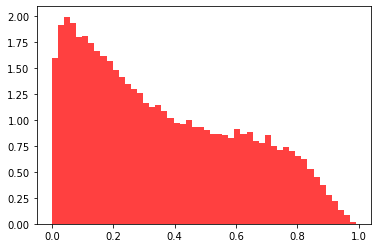

In [113]:
n, bins, patches = plt.hist(log_Predictions_2['RESPONSE'], 50, density=True, facecolor ='r', alpha=0.75)

In [114]:
log_test_predictions_binary_2 = LogModel_2.predict(mailout_test_to_score)

In [115]:
log_Predictions_binary_2 = pd.DataFrame(columns = ['LNR','RESPONSE'])
log_Predictions_binary_2['LNR'] = LNR
log_Predictions_binary_2['RESPONSE'] = log_test_predictions_binary_2

In [116]:
log_Predictions_binary_2.head()

,LNR,RESPONSE
0,1754.0,1
1,1770.0,1
2,1465.0,0
3,1470.0,0
4,1478.0,0


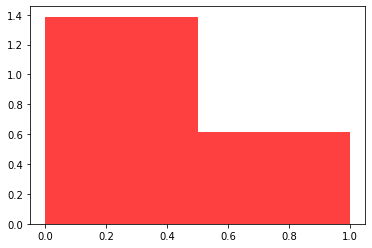

In [117]:
n, bins, patches = plt.hist(log_Predictions_binary_2['RESPONSE'], 2, density=True, facecolor ='r', alpha=0.75)

In [118]:
Test_accepts_log_2 = log_Predictions_binary_2.loc[log_Predictions_binary_2['RESPONSE'] == 1]

In [119]:
Test_accepts_log_2.shape[0]/log_Predictions_binary_2.shape[0] * 100

30.685794261721483

with no sampling as a check it performs much worse. 

In [121]:
LogModel_3 = pickle.load(open('Results/LogModel_test_3.pkl', 'rb'))

In [123]:
log_test_predictions_3 = LogModel_3.predict_proba(mailout_test_to_score)

In [124]:
log_Predictions_3 = pd.DataFrame(columns = ['LNR','RESPONSE'])
log_Predictions_3['LNR'] = LNR
log_Predictions_3['RESPONSE'] = log_test_predictions_3[:,1]

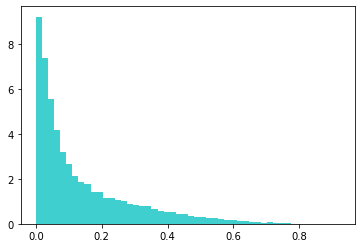

In [126]:
n, bins, patches = plt.hist(log_Predictions_3['RESPONSE'], 50, density=True, facecolor ='c', alpha=0.75)

In [127]:
log_test_predictions_binary_3 = LogModel_3.predict(mailout_test_to_score)

In [128]:
log_Predictions_binary_3 = pd.DataFrame(columns = ['LNR','RESPONSE'])
log_Predictions_binary_3['LNR'] = LNR
log_Predictions_binary_3['RESPONSE'] = log_test_predictions_binary_3

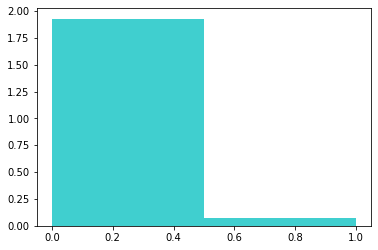

In [129]:
n, bins, patches = plt.hist(log_Predictions_binary_3['RESPONSE'], 2, density=True, facecolor ='c', alpha=0.75)

In [130]:
Test_accepts_log_3 = log_Predictions_binary_3.loc[log_Predictions_binary_3['RESPONSE'] == 1]

In [131]:
Test_accepts_log_3.shape[0]/log_Predictions_binary_3.shape[0] * 100

3.589339864707255

This is much closer to a balanced prediction.

In [132]:
log_Predictions_3.to_csv('Kaggle_predictions/kaggle_probability_predictions.csv', index=False)
log_Predictions_binary_3.to_csv('Kaggle_predictions/kaggle_binary_predictions.csv', index=False)

to_do - 
1. finish off analysis for cluster centers
2. fix that seaborn graph to a matplotlib one
3. tidy up all scripts into a functional process
4. document functions
5. compile some kind of report
6. submit 

In [133]:
cluster_centers_df.head()

,Unnamed: 0,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH
0,0,3.535460,-0.641637,1.015012,-0.681216,-4.220081,0.336008,-0.239587,-0.916983,0.103471,...,-0.021387,0.008341,0.027953,-0.007280,0.028103,-0.037599,-0.030847,-0.017986,-0.043105,-0.001919
1,1,-0.217274,39.909951,11.223507,8.242846,1.342616,0.151597,-0.082740,-0.042895,-0.844324,...,-0.046524,0.024376,-0.071534,0.010132,0.012792,0.041499,-0.003607,0.025548,0.021651,-0.077486
2,2,-4.808584,-2.357121,5.000866,-0.245749,2.135969,-0.369426,0.622371,0.128362,-0.769084,...,-0.001064,0.023258,0.001902,0.014600,0.030524,-0.004656,-0.009255,-0.065090,0.008271,0.032153
3,3,-2.614532,-0.548584,1.615112,0.071416,-4.894031,0.191685,-0.029458,-0.242083,0.418311,...,0.028082,0.016115,0.023655,-0.037181,-0.011475,0.026477,0.025703,0.005171,-0.065703,-0.014585
4,4,6.324426,-1.473750,-1.872796,5.160498,3.252845,3.666517,0.008705,-0.894831,-0.366106,...,0.036752,0.026462,0.001370,0.043877,-0.005129,0.028238,0.008937,-0.010081,0.018358,-0.129392
